In [1]:
import numpy as np
import pymc3 as pm
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [14]:
class LinearRegression:
    '''This class implements a linear regression model using PyMC3. The model is trained on a dataset of acceleration and time data. 
    The model is trained using Bayesian inference and the posterior distribution of the model parameters is plotted. 
    The posterior predictive distribution is also plotted. The model is trained using a Gaussian formulation of the model. 
    '''
    def __init__(self, file_path):
        # Read data from file
        with open(file_path, 'r') as f:
            lines = f.readlines()

        data = []
        for line in lines:
            if not line.startswith('#'):
                row = line.split('\t')
                data.append([col.rstrip() for col in row])

        self.df = pd.DataFrame(data).astype(float)
        self.df.columns = ['times', 'accel', 'strata', 'v']
        self.df.drop(['strata', 'v'], axis=1, inplace=True)

        # Normalize data to be centered around 0 and be between -1 and 1
        self.y = np.array(self.df['times'])  # independent variable (acceleration)
        self.x = np.array(self.df['accel'])  # dependent variable (time)
        self.yn = (self.y - self.y.min()) / (self.y.max() - self.y.min()) * 2 - 1
        self.xn = (self.x - self.x.min()) / (self.x.max() - self.x.min()) * 2 - 1
        
        # Initialize parameters for Bayesian inference
        self.noise = 1 #likelihood noise
        self.prec = 0.1 # precision
        self.n = 10000 # no of samples from posterior distribution
        self.t = 10000 # no of samples to burn in
    
    def gaussian_formulation(self, fixed_precision, likelihood_noise, n_MCS, tunes):
        '''Function takes as argument the fixed precision value of prior on weights, constant likelihood noise and parameters for MCMC computation\
            and returns posterior distribution over the model parameters'''

        # Define model
        with pm.Model() as model:
            # define Gaussian Prior distribution on weights with fixed precision
            w = pm.Normal("w", mu=0, sd=1/np.sqrt(fixed_precision), shape=2) # fixed precision prior on the weights, and mean of 0 

            # define the Likelihood of the data with constant noise, given the model prediction
            mu = w[0] + w[1] * self.xn # specifies the linear regression model. w[0] represent the intercept, w[1] represents the slope
            likelihood = pm.Normal("obs", mu=mu, sd=likelihood_noise, observed=self.yn)

            # Bayesian Inference using MCMC 
            trace = pm.sample(n_MCS, tune=tunes, chains=4, cores=1)
            az.plot_trace(trace, var_names=["w"], figsize=(13, 5))
            plt.suptitle('Posterior Distribution of Model Parameters')

        return trace

    def plot_posterior_predictive_glm_custom(self, trace, eval, lm, samples, **kwargs):
        for rand_loc in np.random.randint(0, len(trace), samples):
            rand_sample = trace[rand_loc]
            plt.plot(eval, lm(eval, rand_sample), **kwargs)
            # Make sure to not plot label multiple times
            kwargs.pop("label", None)

        # Add label to the last line plotted
        if "label" in kwargs:
            plt.plot([], [], label=kwargs["label"], **kwargs)

    def plot_posterior(self, trace):
        with pm.Model():
            az.plot_posterior(trace, var_names=['w'], textsize=18,
                                point_estimate='mean')
            
    def plot_posterior_predictive(self, trace):
        plt.figure(figsize=(7, 7))
        plt.plot(self.x, self.y, "x", label="data")
        self.plot_posterior_predictive_glm_custom(trace, eval=self.x, lm=lambda x, sample: (sample["w"].reshape(-1, 2)[:, 0] + sample["w"].reshape(-1, 2)[:, 1] * x)
        , samples=50, label="posterior predictive regression lines")

        plt.title("Posterior predictive regression lines")
        plt.legend(loc=0)
        plt.xlabel("x")
        plt.ylabel("y")

    def run(self):
        trace = self.gaussian_formulation(fixed_precision = 0.1,likelihood_noise = 1,n_MCS = 10000, tunes = 10000)
        self.plot_posterior(trace)
        self.plot_posterior_predictive(trace)


    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 14 seconds.


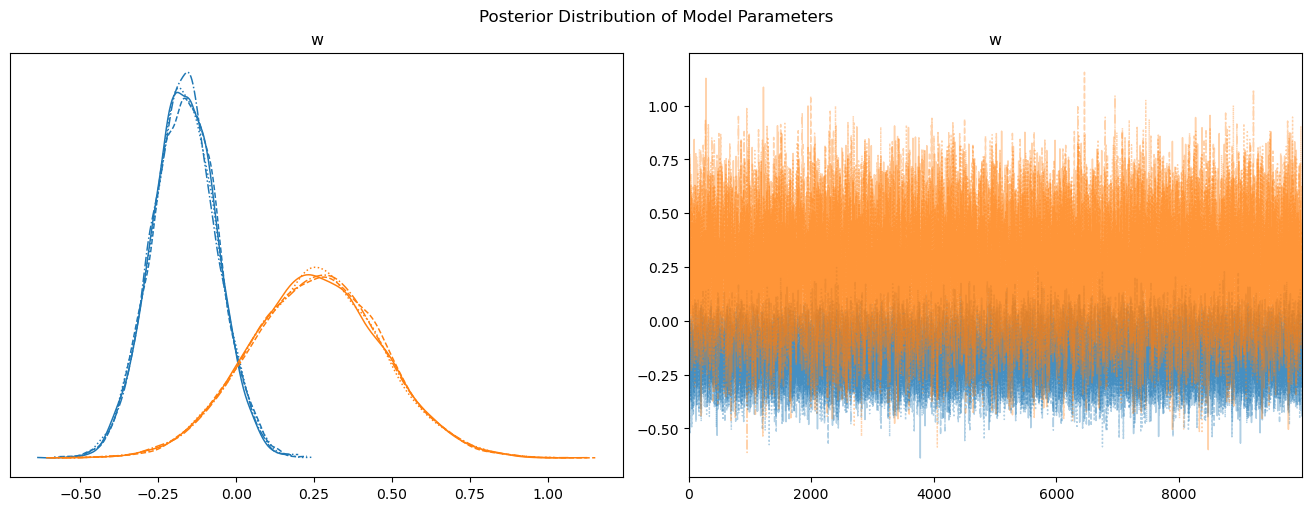

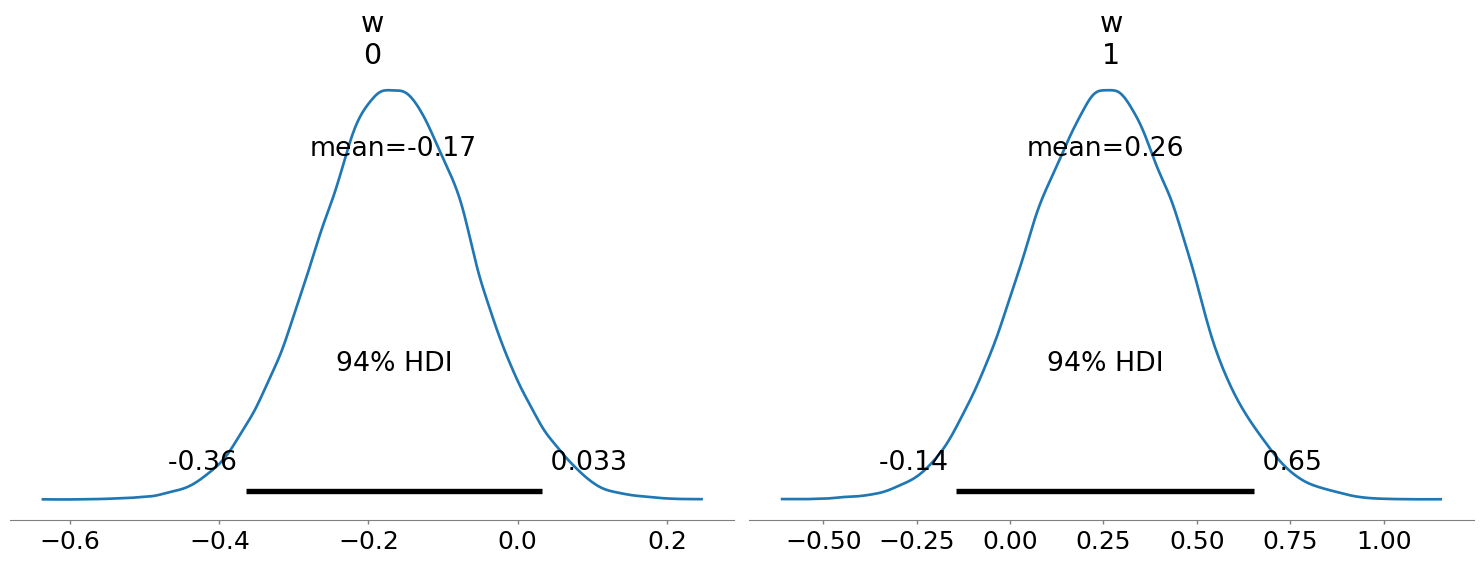

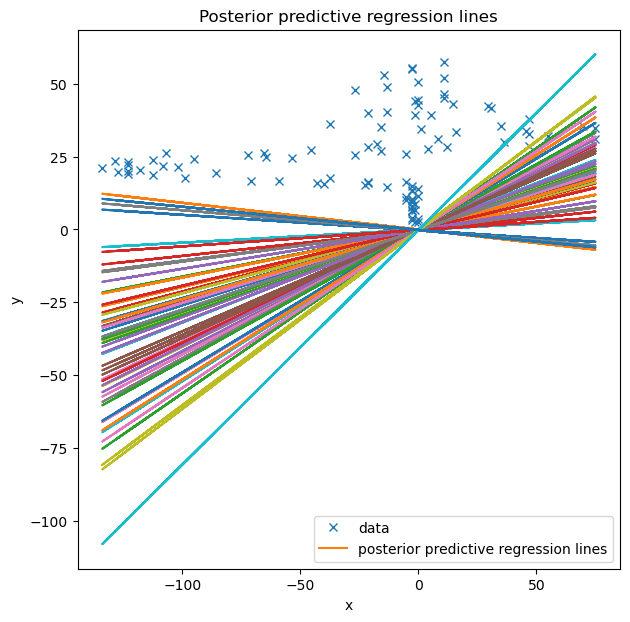

In [15]:
lr = LinearRegression('Motor data/motor.dat')
lr.run()